В этом дз необходимо обучить модели для классификации. Cегодня попробуем отличать настоящие новости от фейковых



In [1]:
# ячейка импортов

import numpy as np
import pandas as pd

# импорт моделей
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

from sklearn.metrics import classification_report # табличка с метриками
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
from collections import Counter
import re
import string

import nltk
from nltk import word_tokenize
from stop_words import get_stop_words
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet

import warnings
warnings.filterwarnings("ignore")
# %matplotlib inline 

# Exploratory Data Analysis (EDA)



In [2]:
! unzip "news_fake-n-true.csv.zip"

"unzip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [3]:
data = pd.read_csv("news_fake-n-true.csv")
data.head(4)

,Unnamed: 0,title,text,subject,date,label
0,0,ADVISORY: Story on Kushner visiting Iraq withd...,(Reuters) - The story “Trump son-in-law Jared ...,politicsNews,"April 3, 2017",1
1,1,Kasich campaign denies report of Romney endors...,WASHINGTON (Reuters) - Republican presidential...,politicsNews,"March 14, 2016",1
2,2,WATCH: Colbert Devises Perfect Advertisement ...,If America is going to end the day Donald Trum...,News,"May 20, 2016",0
3,3,Trump says hopes for Cuban 'freedom' after Cas...,"WEST PALM BEACH, Fla. (Reuters) - U.S. Preside...",politicsNews,"November 26, 2016",1


**колонка label отвечает за тип новости: настоящие имеют лейбл 1,  фейковые новости -- с лейблом 0** 

In [4]:
# создадим новый датафрейм из старого

data_clean = data.drop(['Unnamed: 0','title','subject','date'], axis=1)

display(data_clean)

,text,label
0,(Reuters) - The story “Trump son-in-law Jared ...,1
1,WASHINGTON (Reuters) - Republican presidential...,1
2,If America is going to end the day Donald Trum...,0
3,"WEST PALM BEACH, Fla. (Reuters) - U.S. Preside...",1
4,"Well, it seems that despite the efforts of not...",0
...,...,...
44893,Donald Trump s economic proposals would be dis...,0
44894,INDIANAPOLIS (Reuters) - President Donald Trum...,1
44895,During a private meeting of the most senior Re...,0
44896,"AMMAN (Reuters) - Sabih al-Masri, Jordan s mos...",1


распределение настоящих и фейковых новостей примерно равное

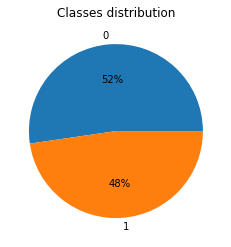

In [5]:
classes = pd.value_counts(data_clean["label"])

classes.plot(kind = 'pie',  autopct='%0.f%%') 
plt.title("Classes distribution")
plt.ylabel('')

plt.show()

**давайте попробуем предсказать:** окажется ли текст настоящей новостью или фейковой

- Векторизуйте тексты
- Разделите данные на обучающую и тестовую выборку

Попробуйте обучить разные модели для классификации на данных
1. Naive Bayes
2. SVM 
3. Decision Trees
4. Random Forest
5. Boosting

Для каждой модели посмотрите на метрики с помощью функции [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).

Какая/какие модель/ли справляются с задачей наиболее эффективно?

**Preprocessing**

In [6]:
data_clean["text"][0]

'(Reuters) - The story “Trump son-in-law Jared Kushner visits Iraq, U.S. official says”, the accompanying alert and subsequent update are wrong and were withdrawn. A substitute story is available here'

In [7]:
def clean_text(text):
    clean_text = re.sub('((?<=[a-z][a-z])[.])(?=[A-Z])', r'\1 ', text)
    clean_text = re.sub('(?<=[a-z][a-z])([:])(?=[A-Z][a-z])', r'\1 ', clean_text)
    clean_text = re.sub('21WIRE.TV', ' ', clean_text)
    clean_text = re.sub('WIRE', ' ', clean_text)
    p = re.compile(r"(\b[-']\b)|[\W_]+|(\b[A-Z]\.+)")
    clean_text = p.sub(lambda m: (m.group(1) if m.group(1) else m.group(2) if m.group(2) else " "), clean_text)
    clean_text = clean_text.lower()
    clean_text = re.sub('https?://\S+|www\.\S+', '', clean_text)
    clean_text = re.sub('\w*\d\w*', '', clean_text)
    clean_text = re.sub('\d+', '', clean_text)
    clean_text = re.sub(' - ', ' ', clean_text)
    return clean_text

In [8]:
data_clean["text"] = data_clean["text"].apply(lambda x: clean_text(x))

In [9]:
data_clean["text"][0]

' reuters the story trump son-in-law jared kushner visits iraq u.s. official says the accompanying alert and subsequent update are wrong and were withdrawn a substitute story is available here'

In [10]:
texts = data_clean['text'].values.tolist()

In [11]:
texts = [word_tokenize(i) for i in texts]

In [12]:
texts[0]

['reuters',
 'the',
 'story',
 'trump',
 'son-in-law',
 'jared',
 'kushner',
 'visits',
 'iraq',
 'u.s.',
 'official',
 'says',
 'the',
 'accompanying',
 'alert',
 'and',
 'subsequent',
 'update',
 'are',
 'wrong',
 'and',
 'were',
 'withdrawn',
 'a',
 'substitute',
 'story',
 'is',
 'available',
 'here']

In [13]:
stop_words = list(get_stop_words('en'))        
nltk_words = list(stopwords.words('english'))
stop_words.extend(nltk_words)
stop_words = set(stop_words)

In [14]:
texts = [[word for word in i if word not in stop_words] for i in texts]

In [15]:
texts[0]

['reuters',
 'story',
 'trump',
 'son-in-law',
 'jared',
 'kushner',
 'visits',
 'iraq',
 'u.s.',
 'official',
 'says',
 'accompanying',
 'alert',
 'subsequent',
 'update',
 'wrong',
 'withdrawn',
 'substitute',
 'story',
 'available']

In [16]:
tag_dict = {
    "N": wordnet.NOUN,
    "V": wordnet.VERB,
    "J": wordnet.ADJ,
    "R": wordnet.ADV
}

In [17]:
tagged_words = [nltk.pos_tag(i) for i in texts]

In [18]:
def extract_wnpostag_from_postag(tag):
    return tag_dict.get(tag[0].upper(), None)

def lemmatize_tupla_word_postag(tupla):
    tag = extract_wnpostag_from_postag(tupla[1])    
    return lemmatizer.lemmatize(tupla[0], tag) if tag is not None else tupla[0]

In [19]:
lemmas = [[lemmatize_tupla_word_postag(word) for word in i] for i in tagged_words]

In [20]:
lemmas[0]

['reuters',
 'story',
 'trump',
 'son-in-law',
 'jar',
 'kushner',
 'visit',
 'iraq',
 'u.s.',
 'official',
 'say',
 'accompany',
 'alert',
 'subsequent',
 'update',
 'wrong',
 'withdrawn',
 'substitute',
 'story',
 'available']

In [21]:
lemmas = [" ".join(i) for i in lemmas]

In [22]:
lemmas[0]

'reuters story trump son-in-law jar kushner visit iraq u.s. official say accompany alert subsequent update wrong withdrawn substitute story available'

In [23]:
data_clean['lemmas'] = lemmas

In [24]:
data_clean = data_clean.drop(["text"], axis = 1)

In [25]:
data_clean

,label,lemmas
0,1,reuters story trump son-in-law jar kushner vis...
1,1,washington reuters republican presidential can...
2,0,america go end day donald trump take nominatio...
3,1,west palm beach fla reuters u.s. president-ele...
4,0,well seem despite effort notoriously crafty se...
...,...,...
44893,0,donald trump economic proposal disastrous econ...
44894,1,indianapolis reuters president donald trump sa...
44895,0,private meeting senior republican senator gop ...
44896,1,amman reuters sabih al-masri jordan influentia...


In [26]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, use_idf=True, sublinear_tf=True, norm='l2', max_features=15000)

In [27]:
X = vectorizer.fit_transform(data_clean['lemmas'])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, data_clean['label'], stratify=data['label'], test_size=0.25, random_state=25)

In [32]:
y_train.value_counts()

0    17610
1    16063
Name: label, dtype: int64

In [33]:
y_test.value_counts()

0    5871
1    5354
Name: label, dtype: int64

**Naive Bayes**

In [111]:
nb_clf = BernoulliNB(alpha=1e-09)
nb_clf.fit(X_train, y_train)

BernoulliNB(alpha=1e-09)

In [112]:
nb_y_pred = nb_clf.predict(X_test)
nb_y_pred

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [113]:
print(classification_report(y_test, nb_y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5871
           1       0.96      0.96      0.96      5354

    accuracy                           0.96     11225
   macro avg       0.96      0.96      0.96     11225
weighted avg       0.96      0.96      0.96     11225



In [114]:
nb_clf.score(X_test, y_test)

0.9635634743875279

In [115]:
nb = nb_clf.score(X_test, y_test)

**SVM**

In [116]:
svm_clf = SVC(kernel='linear', 
              C=10, 
              random_state = 10)
svm_clf.fit(X_train, y_train)

SVC(C=10, kernel='linear', random_state=10)

In [117]:
svm_y_pred = svm_clf.predict(X_test)
svm_y_pred

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [118]:
print(classification_report(y_test, svm_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5871
           1       1.00      1.00      1.00      5354

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [119]:
svm_clf.score(X_test, y_test)

0.9967037861915368

In [120]:
svm = svm_clf.score(X_test, y_test)

**Decision Tree**

In [121]:
tree_clf = DecisionTreeClassifier(max_depth=10,
                                  criterion='entropy', 
                                  random_state=10)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=10)

In [122]:
tree_y_pred = tree_clf.predict(X_test)
tree_y_pred

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [123]:
print(classification_report(y_test, tree_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5871
           1       0.99      1.00      1.00      5354

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [124]:
tree_clf.score(X_test, y_test)

0.9956347438752784

In [125]:
tr = tree_clf.score(X_test, y_test)

**Random Forest**

In [126]:
forest = RandomForestClassifier(n_estimators=1000,
                                criterion='entropy',
                                random_state=10)
forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=1000, random_state=10)

In [127]:
forest_y_pred = forest.predict(X_test)
forest_y_pred

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [128]:
print(classification_report(y_test, forest_y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5871
           1       0.99      1.00      1.00      5354

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [129]:
forest.score(X_test, y_test)

0.9957238307349666

In [130]:
rf = forest.score(X_test, y_test)

**Boosting**

In [131]:
gb_clf = GradientBoostingClassifier(n_estimators=1000,
                                    random_state=10)
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=1000, random_state=10)

In [132]:
gb_y_pred = gb_clf.predict(X_test)
gb_y_pred

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [133]:
print(classification_report(y_test, gb_y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5871
           1       0.99      1.00      1.00      5354

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [134]:
gb_clf.score(X_test, y_test)

0.9957238307349666

In [135]:
gb = gb_clf.score(X_test, y_test)

**Boosting and EarlyStopping**

In [136]:
gb_clf_es = GradientBoostingClassifier(n_iter_no_change=5, 
                                       n_estimators=1000,
                                       random_state=10)
gb_clf_es.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=5,
                           random_state=10)

In [137]:
es_y_pred = gb_clf_es.predict(X_test)
es_y_pred

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [138]:
print(classification_report(y_test, es_y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5871
           1       0.99      1.00      0.99      5354

    accuracy                           1.00     11225
   macro avg       0.99      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [139]:
gb_clf_es.score(X_test, y_test)

0.995011135857461

In [140]:
gb_es = gb_clf_es.score(X_test, y_test)

In [141]:
data_score = {'Models':['Naive Bayes', 'SVM', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Gradient Boosting and EarlyStopping'], 'Score':[nb, svm, tr, rf, gb, gb_es]}

In [142]:
df = pd.DataFrame(data_score)

In [143]:
df

,Models,Score
0,Naive Bayes,0.963563
1,SVM,0.996704
2,Decision Tree,0.995635
3,Random Forest,0.995724
4,Gradient Boosting,0.995724
5,Gradient Boosting and EarlyStopping,0.995011


In [144]:
sorted_df = df.sort_values(by='Score')

In [145]:
sorted_df

,Models,Score
0,Naive Bayes,0.963563
5,Gradient Boosting and EarlyStopping,0.995011
2,Decision Tree,0.995635
3,Random Forest,0.995724
4,Gradient Boosting,0.995724
1,SVM,0.996704


In [ ]:
# Все классификаторы дали примерно одинаковый результат, за исключением Naive Bayes (результат немного хуже).

**Testing new sample**

In [156]:
def input_lemmatization(text):
    text = clean_text(text)
    text = word_tokenize(text)
    text = [word for word in text if word not in stop_words]
    tagged_words = nltk.pos_tag(text)
    lemmas = [lemmatize_tupla_word_postag(word) for word in tagged_words]
    lemmas = ' '.join(lemmas)
    return lemmas

In [147]:
def output_lable(n):
    if n == 0:
        return "Fake news"
    elif n == 1:
        return "Not a fake news"
    
def testing(news):
    test_news = {"text":[news]}
    new_df_test = pd.DataFrame(test_news)
    new_df_test["text"] = new_df_test["text"].apply(input_lemmatization) 
    new_x_test = new_df_test["text"]
    new_xv_test = vectorizer.transform(new_x_test)
    pred_nb_clf = nb_clf.predict(new_xv_test)
    pred_tree_clf = tree_clf.predict(new_xv_test)
    pred_svm_clf = svm_clf.predict(new_xv_test)
    pred_forest = forest.predict(new_xv_test)
    pred_gb_clf = gb_clf.predict(new_xv_test)
    pred_gb_clf_es = gb_clf_es.predict(new_xv_test)
    return print("\nNB Prediction: {} \nSVM Prediction: {} \nTREE Prediction: {} \nFOREST Prediction: {} \nGrB Prediction: {}\nGrB_Es: {}".format(output_lable(pred_nb_clf[0]), 
                                                                                                                                                    output_lable(pred_svm_clf[0]), 
                                                                                                                                                    output_lable(pred_tree_clf[0]), 
                                                                                                                                                    output_lable(pred_forest[0]), 
                                                                                                                                                    output_lable(pred_tree_clf[0]), 
                                                                                                                                                    output_lable(pred_gb_clf[0]), 
                                                                                                                                                    output_lable(pred_gb_clf_es[0])))

In [148]:
real_news = """PALM BEACH, Fla. (Reuters) - President Donald Trump spent Christmas Day golfing at his West Palm Beach club while millions of Americans faced the risk of losing jobless benefits on Saturday and the threat of a partial government shutdown next week if he refuses to sign a $2.3 trillion coronavirus aid and spending package."""

In [164]:
testing(real_news)


NB Prediction: Not a fake news 
SVM Prediction: Not a fake news 
TREE Prediction: Not a fake news 
FOREST Prediction: Not a fake news 
GrB Prediction: Not a fake news
GrB_Es: Not a fake news


In [165]:
fake_news = """It is becoming pretty clear that the Hunan coronovirus is an engineered bio-weapon that was either purposely or accidentally released."""

In [166]:
testing(fake_news)


NB Prediction: Fake news 
SVM Prediction: Fake news 
TREE Prediction: Fake news 
FOREST Prediction: Fake news 
GrB Prediction: Fake news
GrB_Es: Fake news
